In [1]:
import numpy as np

rng = np.random.default_rng(0)

In [2]:
''' Возьмем простые данные - n-мерное изотропное нормальное распределение N(0, I_d) '''

def logp(x):
    return -0.5 * np.dot(x, x)

def grad_logp(x):
    return -x

def logp_mixture(x):
    """Log-плотность смеси двух гауссиан: 0.5*N([-2,-2,...], 0.5*I) + 0.5*N([2,2,...], 0.5*I)"""
    mu1 = -2 * np.ones_like(x)
    mu2 = 2 * np.ones_like(x)
    sigma = 0.5

    logp1 = -0.5 * np.sum((x - mu1)**2) / sigma
    logp2 = -0.5 * np.sum((x - mu2)**2) / sigma

    max_logp = max(logp1, logp2)
    return max_logp + np.log(0.5 * (np.exp(logp1 - max_logp) + np.exp(logp2 - max_logp)))

def grad_logp_mixture(x):
    """Градиент log-плотности смеси"""
    mu1 = -2 * np.ones_like(x)
    mu2 = 2 * np.ones_like(x)
    sigma = 0.5

    logp1 = -0.5 * np.sum((x - mu1)**2) / sigma
    logp2 = -0.5 * np.sum((x - mu2)**2) / sigma

    max_logp = max(logp1, logp2)
    p1 = np.exp(logp1 - max_logp)
    p2 = np.exp(logp2 - max_logp)
    w1 = p1 / (p1 + p2)
    w2 = p2 / (p1 + p2)

    grad1 = -(x - mu1) / sigma
    grad2 = -(x - mu2) / sigma

    return w1 * grad1 + w2 * grad2

In [3]:
''' Посчитаем ESS через интегрированную автокорреляции '''

def ess(x):
    x = x - x.mean()

    acf = np.correlate(x, x, mode='full')
    acf = acf[len(acf) // 2:]
    acf /= acf[0]

    tau = 1 + 2 * np.sum(acf[1:200])

    return len(x) / tau

In [4]:
''' Базовая реализация MH алгоритма '''

def mh(x0, steps, scale, logp_fn):
    x = x0.copy()
    d = len(x)

    chain = np.zeros((steps, d))
    accept = 0

    for t in range(steps):
        prop = x + rng.normal(0, scale, size=d)

        if np.log(rng.uniform()) < (logp_fn(prop) - logp_fn(x)):
            x = prop
            accept += 1

        chain[t] = x

    return chain, accept / steps

In [5]:
# Тут нужно заимплементить Metropolis Adjusted Langevin Algorithm (MALA)

def mala(x0, steps, step, logp_fn, grad_logp_fn):
    """Metropolis Adjusted Langevin Algorithm"""
    x = x0.copy()
    d = len(x)

    chain = np.zeros((steps, d))
    accept = 0

    for t in range(steps):
        grad_x = grad_logp_fn(x)

        mean_prop = x + (step**2 / 2) * grad_x
        prop = mean_prop + step * rng.normal(0, 1, size=d)

        grad_prop = grad_logp_fn(prop)

        mean_back = prop + (step**2 / 2) * grad_prop

        log_q_back = -0.5 * np.sum((x - mean_back)**2) / (step**2)
        log_q_forward = -0.5 * np.sum((prop - mean_prop)**2) / (step**2)

        log_alpha = (logp_fn(prop) - logp_fn(x)) + (log_q_back - log_q_forward)

        if np.log(rng.uniform()) < log_alpha:
            x = prop
            accept += 1

        chain[t] = x

    return chain, accept / steps


In [6]:
d = 10
steps = 30000
burn = 5000
x0 = np.ones(d) * 3 # стартанев в точке 3 например

#mala_step = 0.5  # тут попробуйте подобрать хороший шаг
#mh_scale = 2.0 # тут попробуйте подобрать скейл для пропозала в MH. Может какие-то варианты будут лучше MALA?

#mh_chain, mh_acc = mh(x0, steps, scale=mh_scale)
#mala_chain, mala_acc = mala(x0, steps, step=mala_step)

# Подобранные параметры
mala_step_isotropic = 0.5  # для изотропного гауссиана
mh_scale_isotropic = 2.4    # оптимальный скейл ~2.4/sqrt(d)

mala_step_mixture = 0.3     # для смеси нужен меньший шаг
mh_scale_mixture = 1.5

print("="*60)
print("ЭКСПЕРИМЕНТ 1: Изотропное нормальное распределение N(0, I_d)")
print("="*60)

mh_chain1, mh_acc1 = mh(x0, steps, scale=mh_scale_isotropic, logp_fn=logp)
mala_chain1, mala_acc1 = mala(x0, steps, step=mala_step_isotropic,
                               logp_fn=logp, grad_logp_fn=grad_logp)

# Обрезаем burn-in
mh_chain1_burned = mh_chain1[burn:]
mala_chain1_burned = mala_chain1[burn:]

# Считаем ESS для каждой размерности
mh_ess1 = [ess(mh_chain1_burned[:, i]) for i in range(d)]
mala_ess1 = [ess(mala_chain1_burned[:, i]) for i in range(d)]

print(f"\nMH:")
print(f"  Acceptance rate: {mh_acc1:.3f}")
print(f"  Median ESS: {np.median(mh_ess1):.1f}")

print(f"\nMALA:")
print(f"  Acceptance rate: {mala_acc1:.3f}")
print(f"  Median ESS: {np.median(mala_ess1):.1f}")

print("\n" + "="*60)
print("ЭКСПЕРИМЕНТ 2: Смесь гауссиан")
print("="*60)

mh_chain2, mh_acc2 = mh(x0, steps, scale=mh_scale_mixture, logp_fn=logp_mixture)
mala_chain2, mala_acc2 = mala(x0, steps, step=mala_step_mixture,
                               logp_fn=logp_mixture, grad_logp_fn=grad_logp_mixture)

mh_chain2_burned = mh_chain2[burn:]
mala_chain2_burned = mala_chain2[burn:]

mh_ess2 = [ess(mh_chain2_burned[:, i]) for i in range(d)]
mala_ess2 = [ess(mala_chain2_burned[:, i]) for i in range(d)]

print(f"\nMH:")
print(f"  Acceptance rate: {mh_acc2:.3f}")
print(f"  Median ESS: {np.median(mh_ess2):.1f}")

print(f"\nMALA:")
print(f"  Acceptance rate: {mala_acc2:.3f}")
print(f"  Median ESS: {np.median(mala_ess2):.1f}")


ЭКСПЕРИМЕНТ 1: Изотропное нормальное распределение N(0, I_d)

MH:
  Acceptance rate: 0.004
  Median ESS: 95.4

MALA:
  Acceptance rate: 0.959
  Median ESS: 1638.0

ЭКСПЕРИМЕНТ 2: Смесь гауссиан

MH:
  Acceptance rate: 0.005
  Median ESS: 101.3

MALA:
  Acceptance rate: 0.975
  Median ESS: 1303.6


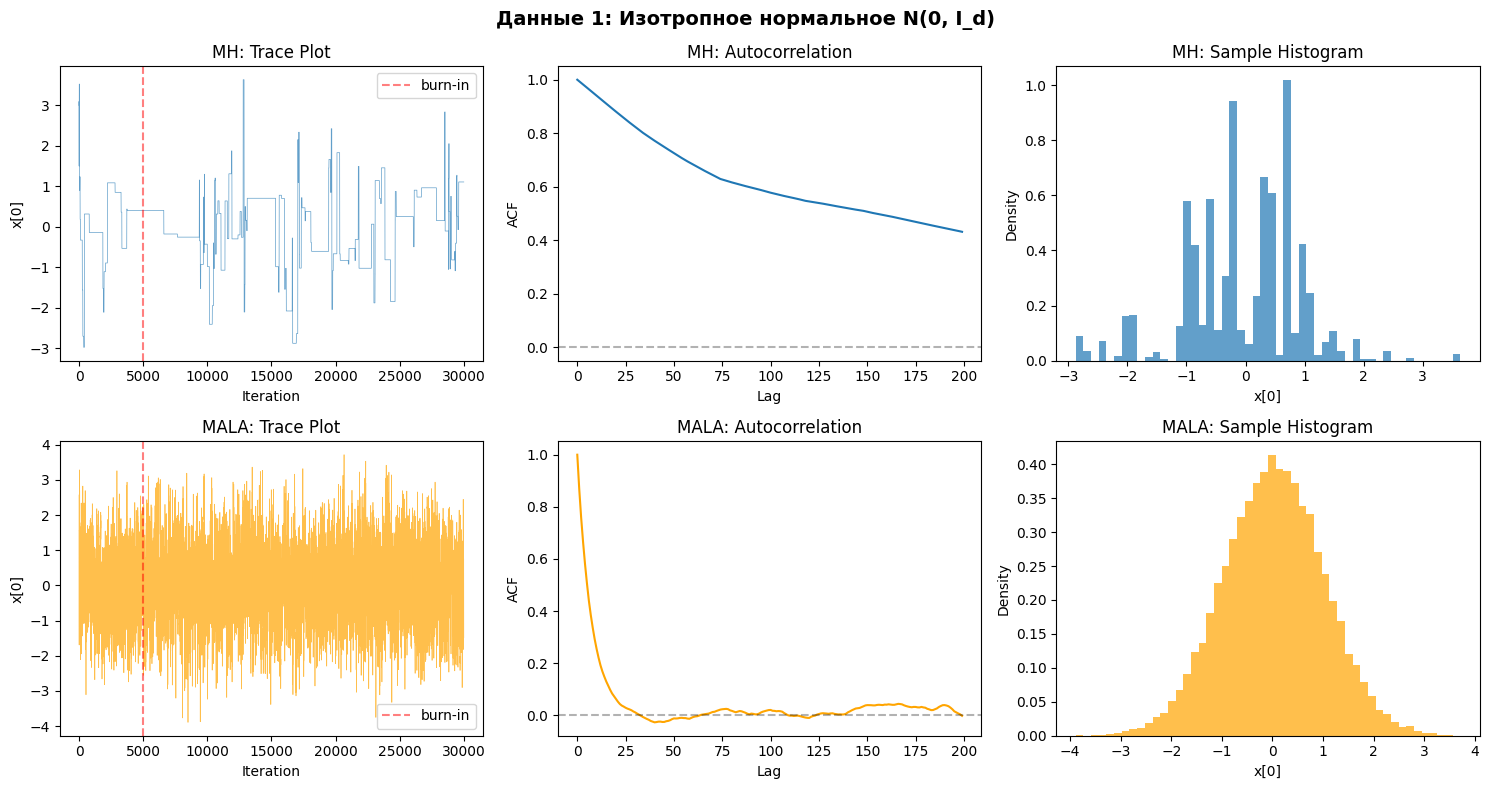

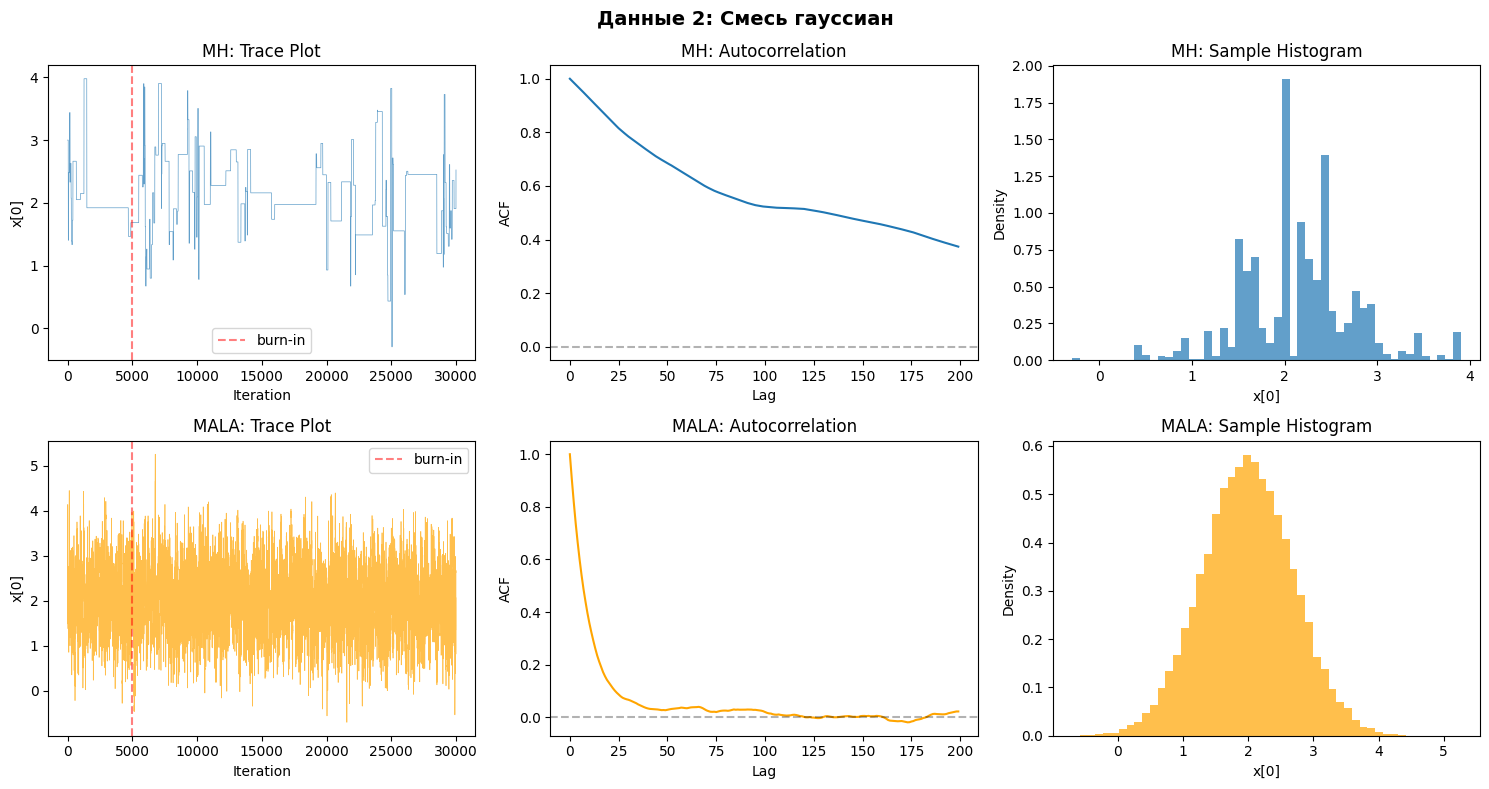

In [7]:
# Здесь нарисуйте 3 графика: trace plot (значение цепи vs итерация),
# график автокорреляции (значение ACF vs задержка по времени) и гистограмма семплов (возьмите какую-то одну размерность)

import matplotlib.pyplot as plt

def plot_diagnostics(chain_mh, chain_mala, title, dim=0):
    """Строит диагностические графики для одной размерности"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    fig.suptitle(title, fontsize=14, fontweight='bold')

    # --- MH ---
    # Trace plot
    axes[0, 0].plot(chain_mh[:, dim], alpha=0.7, linewidth=0.5)
    axes[0, 0].set_title('MH: Trace Plot')
    axes[0, 0].set_xlabel('Iteration')
    axes[0, 0].set_ylabel(f'x[{dim}]')
    axes[0, 0].axvline(burn, color='r', linestyle='--', alpha=0.5, label='burn-in')
    axes[0, 0].legend()

    # ACF
    x_mh = chain_mh[burn:, dim] - chain_mh[burn:, dim].mean()
    acf_mh = np.correlate(x_mh, x_mh, mode='full')
    acf_mh = acf_mh[len(acf_mh) // 2:]
    acf_mh /= acf_mh[0]
    lags = min(200, len(acf_mh))
    axes[0, 1].plot(acf_mh[:lags])
    axes[0, 1].set_title('MH: Autocorrelation')
    axes[0, 1].set_xlabel('Lag')
    axes[0, 1].set_ylabel('ACF')
    axes[0, 1].axhline(0, color='k', linestyle='--', alpha=0.3)

    # Histogram
    axes[0, 2].hist(chain_mh[burn:, dim], bins=50, density=True, alpha=0.7)
    axes[0, 2].set_title('MH: Sample Histogram')
    axes[0, 2].set_xlabel(f'x[{dim}]')
    axes[0, 2].set_ylabel('Density')

    # --- MALA ---
    # Trace plot
    axes[1, 0].plot(chain_mala[:, dim], alpha=0.7, linewidth=0.5, color='orange')
    axes[1, 0].set_title('MALA: Trace Plot')
    axes[1, 0].set_xlabel('Iteration')
    axes[1, 0].set_ylabel(f'x[{dim}]')
    axes[1, 0].axvline(burn, color='r', linestyle='--', alpha=0.5, label='burn-in')
    axes[1, 0].legend()

    # ACF
    x_mala = chain_mala[burn:, dim] - chain_mala[burn:, dim].mean()
    acf_mala = np.correlate(x_mala, x_mala, mode='full')
    acf_mala = acf_mala[len(acf_mala) // 2:]
    acf_mala /= acf_mala[0]
    axes[1, 1].plot(acf_mala[:lags], color='orange')
    axes[1, 1].set_title('MALA: Autocorrelation')
    axes[1, 1].set_xlabel('Lag')
    axes[1, 1].set_ylabel('ACF')
    axes[1, 1].axhline(0, color='k', linestyle='--', alpha=0.3)

    # Histogram
    axes[1, 2].hist(chain_mala[burn:, dim], bins=50, density=True, alpha=0.7, color='orange')
    axes[1, 2].set_title('MALA: Sample Histogram')
    axes[1, 2].set_xlabel(f'x[{dim}]')
    axes[1, 2].set_ylabel('Density')

    plt.tight_layout()
    plt.show()

# Графики для изотропного распределения
plot_diagnostics(mh_chain1, mala_chain1,
                'Данные 1: Изотропное нормальное N(0, I_d)', dim=0)

# Графики для смеси гауссиан
plot_diagnostics(mh_chain2, mala_chain2,
                'Данные 2: Смесь гауссиан', dim=0)
